
# Credit Spread + Climate Add-on — Notebook Didattico (ordinato)



**Flusso sintetico**
1. FRED (pandas_datareader): IG OAS + risk-free (timeline + curva)
2. IPCC/OWID: annualizzazione (interpolazione), Δ% YoY robusto, z-score
3. PCA: explained variance per 4 scenari (bar + cumulata)
4. Shock settoriali (regole trasparenti) → ΔPD → Δλ → Δ spread (IG/HY)


In [16]:

# === Parametri ================================================================
IPCC_CSV_PATH = "/Users/emanuelemigliaccio/Climate-Risk-Project/data/owid_ipcc_scenarios.csv"
SELECTED_SCENARIOS = ["SSP1 - 1.9","SSP2 - 4.5","SSP3 - 6.0","SSP5 - 6.0"]

CHI, ALPHA, LGD_BASE, DT = 1.0, 1.0, 0.60, 1.0

SECTORS = ["Fossil_Fuels", "Utilities_Fossil", "Renewables"]
SECTOR_EXPOSURES = {
    "US_IG_Synthetic": {"Fossil_Fuels":0.15, "Utilities_Fossil":0.20, "Renewables":0.10, "Other":0.55},
    "US_HY_Synthetic": {"Fossil_Fuels":0.25, "Utilities_Fossil":0.15, "Renewables":0.05, "Other":0.55},
}
BASELINE_PD = {"US_IG_Synthetic":0.01, "US_HY_Synthetic":0.05}


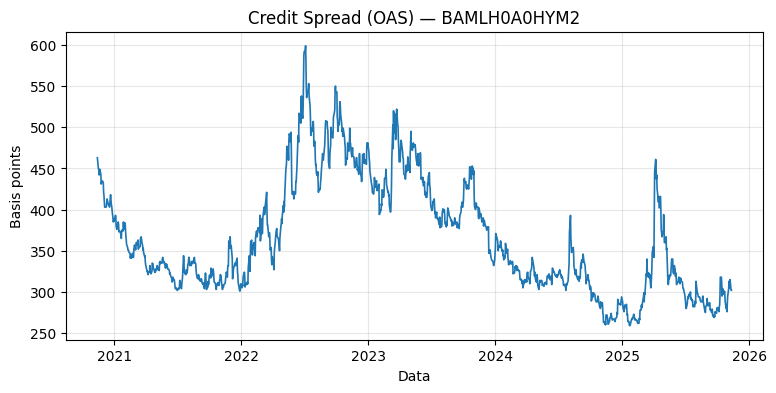

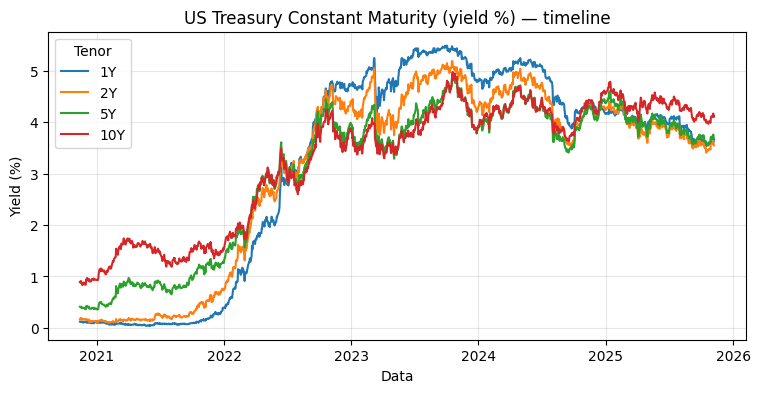

In [17]:

# === 1) FRED: IG OAS (bps) e risk-free (timeline + curva) ====================
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import numpy as np

# HY OAS
df_hy = pdr.DataReader("BAMLH0A0HYM2", "fred").reset_index().rename(columns={"DATE":"Date","BAMLH0A0HYM2":"value"})
df_hy["value"] = pd.to_numeric(df_hy["value"], errors="coerce")
if df_hy["value"].max() < 10: df_hy["value"] *= 100.0
df_hy = df_hy.dropna().sort_values("Date").reset_index(drop=True)

plt.figure(figsize=(9,4))
plt.plot(df_hy["Date"], df_hy["value"], lw=1.2)
plt.title("Credit Spread (OAS) — BAMLH0A0HYM2")
plt.xlabel("Data"); plt.ylabel("Basis points"); plt.grid(True, alpha=0.3)
plt.show()

# Risk-free
rf_codes = {"DGS1":"1Y", "DGS2":"2Y", "DGS5":"5Y", "DGS10":"10Y"}
rf_frames = []
for code, label in rf_codes.items():
    tmp = pdr.DataReader(code, "fred").reset_index().rename(columns={"DATE":"Date", code:"value"}); tmp["label"]=label; rf_frames.append(tmp)
rf = pd.concat(rf_frames, ignore_index=True).dropna().sort_values(["label","Date"]).reset_index(drop=True)

plt.figure(figsize=(9,4))
for label in sorted(rf["label"].unique(), key=lambda x: int(x.replace("Y",""))):
    dd = rf[rf["label"]==label].sort_values("Date").tail(3650)
    plt.plot(dd["Date"], dd["value"], label=label)
plt.title("US Treasury Constant Maturity (yield %) — timeline")
plt.xlabel("Data"); plt.ylabel("Yield (%)"); plt.legend(title="Tenor"); plt.grid(True, alpha=0.3); plt.show()



In [18]:
# === 2) IPCC: annualizzazione, Δ% YoY robusto, z-score =======================


df_raw = pd.read_csv(IPCC_CSV_PATH)
assert "Scenario" in df_raw.columns and "Year" in df_raw.columns

region_cols = [c for c in df_raw.columns if c.lower() in ("region","country")]
if region_cols:
    key = region_cols[0]; mask_world = df_raw[key].astype(str).str.upper().isin(["WORLD","GLOBAL","WLD"])
    if mask_world.any(): df_raw = df_raw[mask_world].copy()

meta_cols = ["Scenario","Year"]
num_cols  = [c for c in df_raw.columns if c not in meta_cols and np.issubdtype(df_raw[c].dtype, np.number)]
df_num    = df_raw[meta_cols + num_cols].copy().sort_values(["Scenario","Year"])

def interpolate_annual(df_in, scen_col="Scenario", year_col="Year"):
    out=[]; nc=[c for c in df_in.columns if c not in (scen_col, year_col) and np.issubdtype(df_in[c].dtype, np.number)]
    for s,g in df_in.groupby(scen_col):
        g=g.sort_values(year_col).copy(); y_min,y_max=int(g[year_col].min()), int(g[year_col].max())
        grid=pd.DataFrame({scen_col:s, year_col:np.arange(y_min,y_max+1)})
        gg=pd.merge(grid, g[[scen_col,year_col]+nc], on=[scen_col,year_col], how="left")
        for c in nc: gg[c]=gg[c].interpolate(method="linear", limit_direction="both")
        out.append(gg)
    return pd.concat(out, ignore_index=True)

def pct_change_robust(X):
    eps=1e-12; prev=X.shift(1); denom=np.maximum(np.abs(prev), eps); out=(X-prev)/denom*100.0
    return out.replace([np.inf,-np.inf], np.nan)

def pct_change_by_scenario_interpolated(df_in, scen_col="Scenario", year_col="Year"):
    out=[]; nc=[c for c in df_in.columns if c not in (scen_col,year_col) and np.issubdtype(df_in[c].dtype, np.number)]
    for s,g in df_in.groupby(scen_col):
        g=g.sort_values(year_col).copy(); X=g[nc]; X_pct=X.apply(pct_change_robust)
        tmp=pd.concat([g[[scen_col,year_col]].reset_index(drop=True), X_pct.reset_index(drop=True)], axis=1); out.append(tmp)
    return pd.concat(out, ignore_index=True)

def zscore_cols(df_in, skip=("Scenario","Year")):
    df_out=df_in.copy()
    for c in df_out.columns:
        if c in skip: continue
        col=df_out[c]; mu,sd=np.nanmean(col), np.nanstd(col)
        df_out[c]=(col-mu)/sd if (np.isfinite(mu) and np.isfinite(sd) and sd>0) else np.nan
    return df_out

df_interp = interpolate_annual(df_num)
df_d      = pct_change_by_scenario_interpolated(df_interp)
df_z_raw  = zscore_cols(df_d, skip=("Scenario","Year"))

MIN_COVERAGE, MIN_STD = 0.80, 1e-8
feature_cols = []
for c in [c for c in df_z_raw.columns if c not in ("Scenario","Year")]:
    coverage = df_z_raw[c].notna().mean(); sd = np.nanstd(df_z_raw[c])
    if (coverage >= MIN_COVERAGE) and (sd > MIN_STD): feature_cols.append(c)
if len(feature_cols)==0:
    for c in [c for c in df_z_raw.columns if c not in ("Scenario","Year")]:
        coverage = df_z_raw[c].notna().mean(); sd = np.nanstd(df_z_raw[c])
        if (coverage >= 0.50) and (sd > MIN_STD): feature_cols.append(c)

df_z   = df_z_raw[["Scenario","Year"]+feature_cols].copy()
df_pca = df_z.copy()
for c in feature_cols: df_pca[c]=df_pca[c].fillna(0.0)

print(f"Feature per PCA: {len(feature_cols)}"); df_pca.head(3)


Feature per PCA: 143


/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_5165/1319192895.py:41: RuntimeWarning: Mean of empty slice
  col=df_out[c]; mu,sd=np.nanmean(col), np.nanstd(col)
/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,Scenario,Year,Livestock demand,Energy crop production,Non-energy crop production,Livestock production,Carbon price,Methane concentration,CO2 concentration,Nitrous oxide concentration,...,"Secondary electricity (%, wind)",Carbon intensity of economy,Carbon intensity of energy,Primary energy intensity,Final energy intensity,Final energy as a share of primary energy,final_energy_biomass,final_energy_coal,primary_energy_intensity,final_energy_intensity
0,SSP1 - 1.9,2005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,SSP1 - 1.9,2006,1.648702,-0.063121,2.688785,1.639503,-0.039208,1.554904,0.479516,0.867591,...,4.998756,0.083440,0.092971,0.057489,-0.427891,-1.852476,1.692776,1.273925,0.057489,-0.427891
2,SSP1 - 1.9,2007,1.602887,-0.063121,2.607196,1.593434,-0.039208,1.545577,0.471357,0.860124,...,3.523078,0.083033,0.092931,0.032190,-0.471623,-1.860392,1.652211,1.231125,0.032190,-0.471623


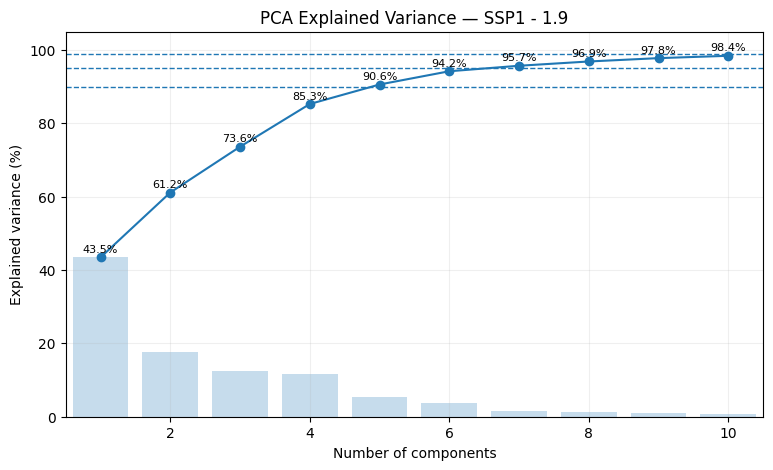

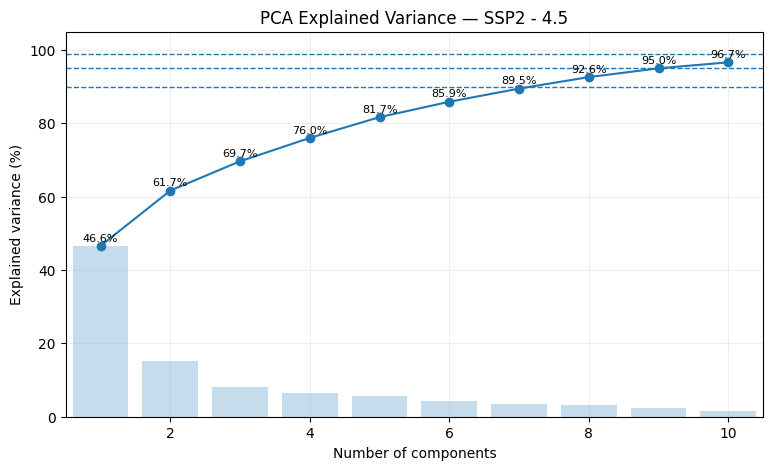

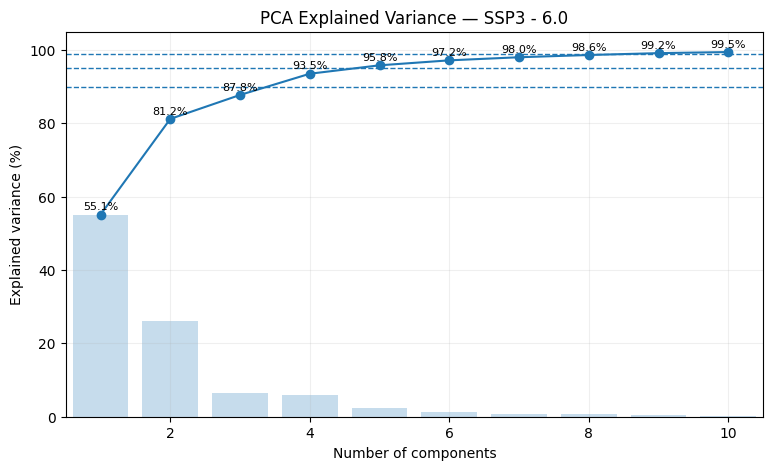

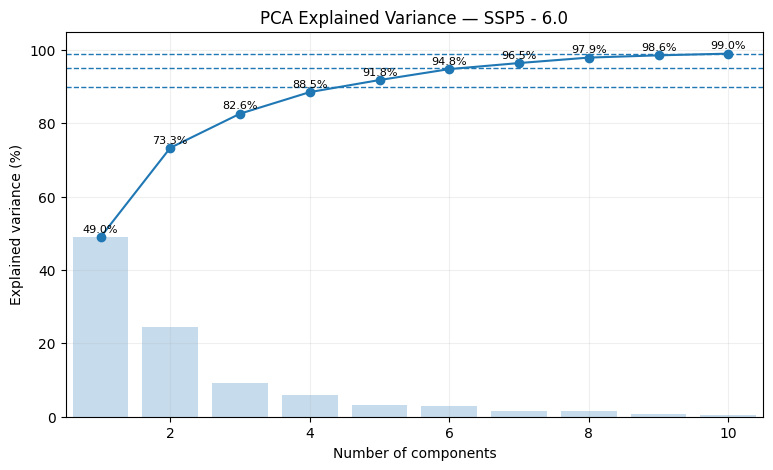

In [19]:

# === 3) PCA explained variance: funzione + grafico per 4 scenari =============
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca_explained_variance_by_scenario(df_pca, scenario, max_components=10):
    g=df_pca[df_pca["Scenario"]==scenario].sort_values("Year")
    feat=[c for c in df_pca.columns if c not in ("Scenario","Year")]
    if g.empty or len(feat)==0: return None,None,None
    X=g[feat].to_numpy(); n_sample,n_feat=X.shape
    if n_sample<2 or n_feat<1: return None,None,None
    n_comp=int(min(max_components, n_feat, n_sample)); pca=PCA(n_components=n_comp).fit(X)
    comps=list(range(1,n_comp+1)); evr=pca.explained_variance_ratio_*100.0; evr_cum=evr.cumsum()
    return comps, evr, evr_cum

for scen in SELECTED_SCENARIOS:
    comps, evr, evr_cum = pca_explained_variance_by_scenario(df_pca, scen, max_components=10)
    if comps is None:
        print(f"PCA non disponibile per: {scen}"); continue
    plt.figure(figsize=(9,5))
    plt.bar(comps, evr, alpha=0.25)
    plt.plot(comps, evr_cum, marker="o")
    for thr in [90,95,99]: plt.axhline(thr, linestyle="--", linewidth=1)
    for x,y in zip(comps, evr_cum): plt.text(x, y+0.8, f"{y:.1f}%", ha="center", va="bottom", fontsize=8)
    plt.title(f"PCA Explained Variance — {scen}")
    plt.xlabel("Number of components"); plt.ylabel("Explained variance (%)")
    plt.ylim(0,105); plt.xlim(0.5, max(comps)+0.5); plt.grid(alpha=0.2); plt.show()


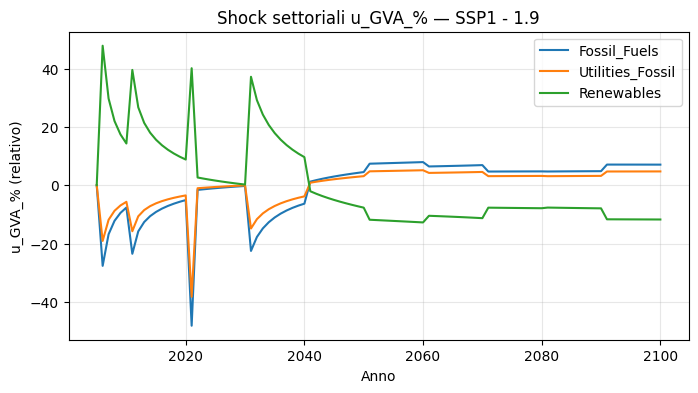

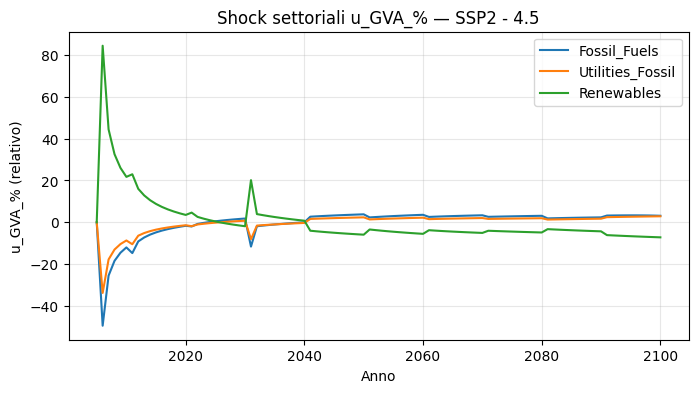

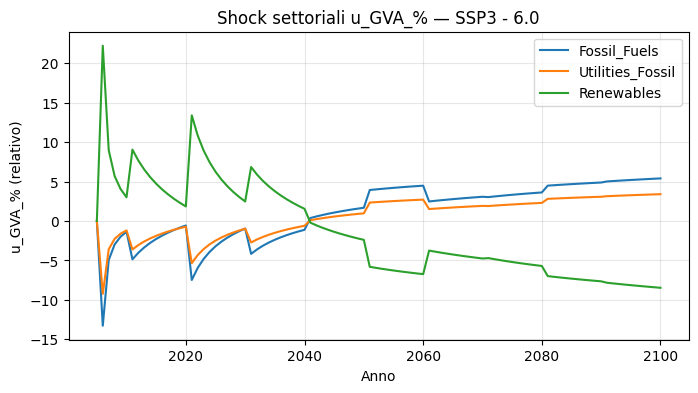

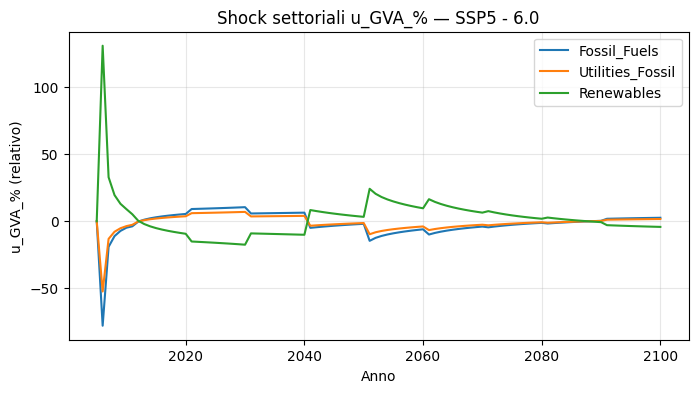

In [20]:

# === 4) Shock settoriali (regole trasparenti) =================================
import re, pandas as pd

sector_rules = {
    "Fossil_Fuels": [(r"^primary_energy_(coal|oil|gas)$", +1.0),
                     (r"^final_energy_(coal|oil|gas)$", +0.8),
                     (r"carbon.*price", -1.0),
                     (r"co2(_|$)", -0.5),
                     (r"renew|solar|wind|hydro|bioenergy|geothermal|ocean", -0.6),],
    "Utilities_Fossil": [(r"^primary_energy_(coal|gas)$", +0.8),
                         (r"carbon.*price", -0.8),
                         (r"renew|solar|wind|hydro|bioenergy|geothermal|ocean", -0.4),],
    "Renewables": [(r"renew|solar|wind|hydro|bioenergy|geothermal|ocean", +1.0),
                   (r"carbon.*price", +0.8),
                   (r"^primary_energy_(coal|oil|gas)$", -0.8),]
}

def weight_for_col(colname, rules):
    w=0.0
    for pattern, sign in rules:
        if re.search(pattern, colname, re.IGNORECASE): w+=sign
    return w

col_weights = {sec: {c: weight_for_col(c, sector_rules[sec]) for c in [c for c in df_pca.columns if c not in ('Scenario','Year')]}
               for sec in SECTORS}

rows=[]
for (scen,g) in df_pca.groupby("Scenario"):
    for _, r in g.iterrows():
        year=int(r["Year"])
        for sec in SECTORS:
            score=0.0
            for c,w in col_weights[sec].items():
                if w==0.0: continue
                v=r[c]
                if pd.notna(v): score += w*v
            rows.append({"Scenario":scen,"Year":year,"Sector":sec,"u_GVA_%":score})

scenario_shocks = pd.DataFrame(rows).sort_values(["Scenario","Year","Sector"])

# Grafico per gli scenari selezionati
for scen in SELECTED_SCENARIOS:
    g = scenario_shocks[scenario_shocks["Scenario"]==scen].pivot(index="Year", columns="Sector", values="u_GVA_%").sort_index()
    if g.empty: print(f"Nessuno shock per: {scen}"); continue
    plt.figure(figsize=(8,4))
    for sec in SECTORS:
        if sec in g.columns: plt.plot(g.index, g[sec], label=sec)
    plt.title(f"Shock settoriali u_GVA_% — {scen}")
    plt.xlabel("Anno"); plt.ylabel("u_GVA_% (relativo)"); plt.legend(); plt.grid(alpha=0.3); plt.show()


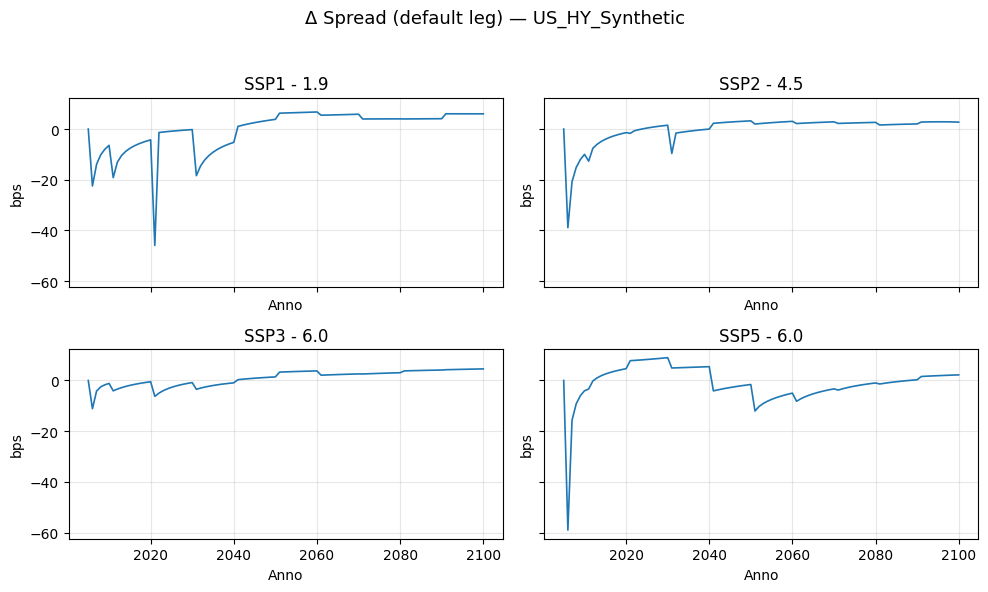

In [21]:

# === 5) ΔPD → Δλ → Δ spread (default leg) IG/HY + griglie 2×2 =================
import numpy as np
import matplotlib.pyplot as plt

def pd_to_lambda(pd_annual, dt=1.0):
    pd_annual = max(1e-8, min(0.999999, float(pd_annual)))
    return -np.log(1.0 - pd_annual) / max(1e-8, dt)
def apply_xi_to_pd(pd_base, xi, alpha=1.0):
    return max(1e-8, min(0.999999, pd_base * np.exp(alpha * xi)))

rows=[]
for issuer, weights in SECTOR_EXPOSURES.items():
    pd0=BASELINE_PD.get(issuer, 0.02); lam0=pd_to_lambda(pd0, DT)
    for (scen,y), g in scenario_shocks.groupby(["Scenario","Year"]):
        xi=0.0
        for sec,w in weights.items():
            if sec=="Other": continue
            u=g.loc[g["Sector"]==sec, "u_GVA_%"]
            if not u.empty: xi += CHI*w*(float(u.iloc[0])/100.0)
        pd1=apply_xi_to_pd(pd0, xi, ALPHA); lam1=pd_to_lambda(pd1, DT)
        dspread_bps=LGD_BASE*(lam1-lam0)*1e4
        rows.append({"Issuer":issuer,"Scenario":scen,"Year":int(y),"Delta_Spread_bps":dspread_bps})

df_spread = pd.DataFrame(rows).sort_values(["Issuer","Scenario","Year"])

def plot_spread_grid(df_spread, issuer, scenarios):
    fig, axes = plt.subplots(2,2, figsize=(10,6), sharex=True, sharey=True); axes=axes.flatten()
    for ax, scen in zip(axes, scenarios):
        g=df_spread[(df_spread['Issuer']==issuer)&(df_spread['Scenario']==scen)].sort_values('Year')
        if g.empty: ax.set_visible(False); continue
        ax.plot(g['Year'], g['Delta_Spread_bps'], lw=1.2)
        ax.set_title(scen); ax.set_xlabel("Anno"); ax.set_ylabel("bps"); ax.grid(alpha=0.3)
    fig.suptitle(f"Δ Spread (default leg) — {issuer}", fontsize=13); plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

plot_spread_grid(df_spread, "US_HY_Synthetic", SELECTED_SCENARIOS)


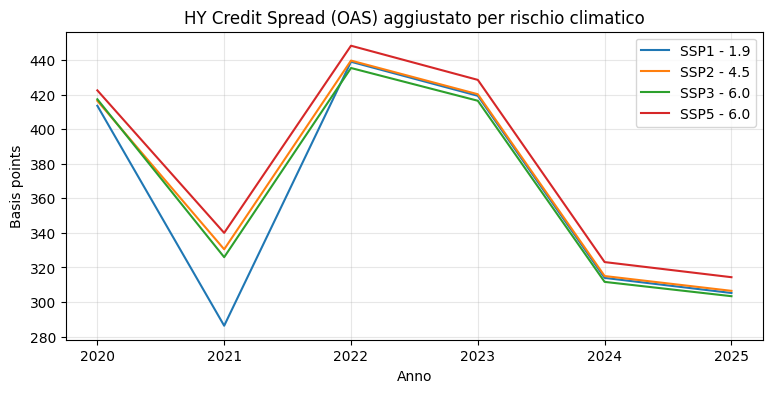

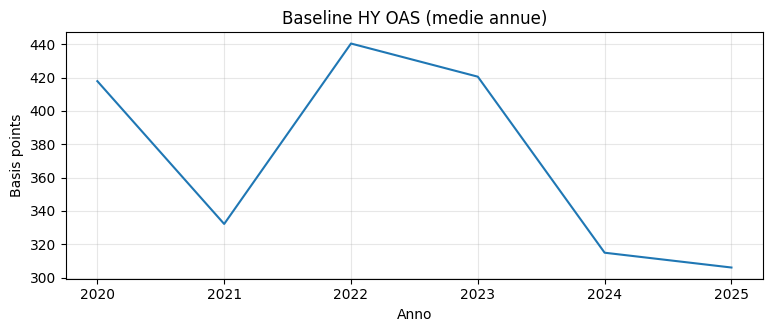

In [23]:
# === Finale: curve HY OAS aggiustate per rischio climatico (per scenario) ===
import pandas as pd
import matplotlib.pyplot as plt

issuer = "US_HY_Synthetic"

# 1) Baseline IG OAS: medie annue (per allineare al passo degli shock)
ig_yearly = (df_hy.assign(Year=df_hy["Date"].dt.year)
                 .groupby("Year", as_index=False)["value"].mean()
                 .rename(columns={"value":"HY_OAS_bps"}))

# 2) Costruisco le serie "HY_OAS_bps + Δspread_clima" per ciascuno scenario
adj_list = []
for scen in SELECTED_SCENARIOS:
    add = (df_spread[(df_spread["Issuer"]==issuer) & (df_spread["Scenario"]==scen)]
              [["Year","Delta_Spread_bps"]])
    ser = ig_yearly.merge(add, on="Year", how="inner")
    ser["Adj_OAS_bps"] = ser["HY_OAS_bps"] + ser["Delta_Spread_bps"]
    ser["Scenario"] = scen
    adj_list.append(ser[["Year","Scenario","Adj_OAS_bps","HY_OAS_bps","Delta_Spread_bps"]])

adj_ig = pd.concat(adj_list, ignore_index=True).sort_values(["Scenario","Year"])

# 3) Plot: quattro curve (una per scenario)
plt.figure(figsize=(9,4))
for scen, g in adj_ig.groupby("Scenario"):
    plt.plot(g["Year"], g["Adj_OAS_bps"], label=scen)
plt.title("HY Credit Spread (OAS) aggiustato per rischio climatico")
plt.xlabel("Anno"); plt.ylabel("Basis points"); plt.grid(True, alpha=0.3); plt.legend()
plt.show()

# (Opzionale) Mostra anche la baseline per confronto
plt.figure(figsize=(9,3.2))
plt.plot(ig_yearly["Year"], ig_yearly["HY_OAS_bps"])
plt.title("Baseline HY OAS (medie annue)")
plt.xlabel("Anno"); plt.ylabel("Basis points"); plt.grid(True, alpha=0.3)
plt.show()


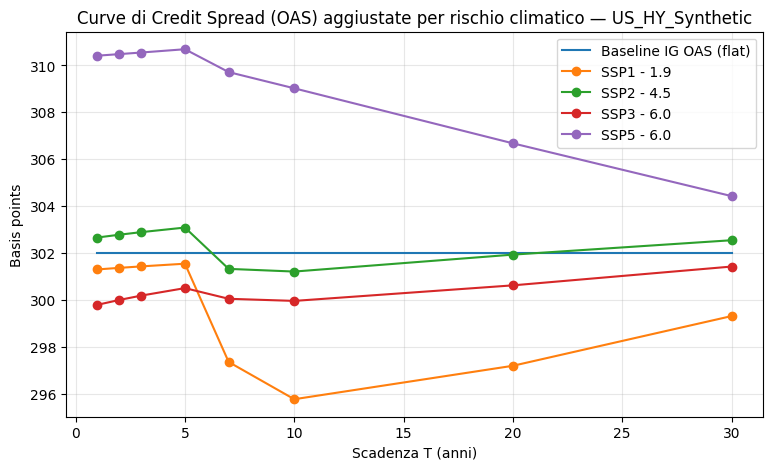

In [ ]:
# === CURVE per SCADENZA: hazard term-structure + climate add-on ===============

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# INPUT attesi esistenti nel notebook:
# - rf           : DataFrame con colonne ['Date','value','label'] per DGS1/2/5/10 (yield %)
# - df_ig        : IG OAS timeseries (bps), colonne ['Date','value']
# - df_spread    : add-on climatico annuo, colonne ['Issuer','Scenario','Year','Delta_Spread_bps']
# - SELECTED_SCENARIOS
# - issuer       : scegli "US_IG_Synthetic" o "US_HY_Synthetic"
issuer = "US_HY_Synthetic"

# 0) Tenori per la curva
TENORS_Y = np.array([1,2,3,5,7,10,20,30], dtype=float)

# 1) Risk-free discount factors (continua) dai DGS (snapshot all'ultima data comune)
last_common_date = rf.groupby("label")["Date"].max().min()
snap = rf[rf["Date"]==last_common_date].copy()
# mappa label -> anni (1,2,5,10)
snap["T"] = snap["label"].str.replace("Y","", regex=False).astype(float)
# interpolazione sul set di TENORS
rf_curve = np.interp(TENORS_Y, snap["T"].values, snap["value"].values)  # yield in %
# fattori di sconto continui: P(T) = exp(-y*T) con y a frazione (es. 3.5% -> 0.035)
P_rf = np.exp(-(rf_curve/100.0)*TENORS_Y)

# 2) Baseline spread term-structure (semplice): piatto = ultimo IG OAS
#    -> in pratica useresti una curva OAS per scadenza; per didattica usiamo flat
s_base_last = float(df_ig["value"].iloc[-1])  # bps
s_base_curve = np.full_like(TENORS_Y, s_base_last, dtype=float)

# 3) Trasforma l’add-on annuo in Δλ(t) (hazard increment) e in Δs(t)
#    Δλ(t) = Δs(t) / (LGD * 1e4). Qui Δs è già in bps nel df_spread.
def climate_lambda_path(df_spread, issuer, scenario, lgd=0.60):
    g = df_spread[(df_spread["Issuer"]==issuer) & (df_spread["Scenario"]==scenario)].sort_values("Year")
    if g.empty:
        return pd.DataFrame(columns=["Year","Delta_lambda","Delta_s_bps"])
    out = g.copy()
    out["Delta_lambda"] = (out["Delta_Spread_bps"] / (lgd * 1e4)).astype(float)
    out = out.rename(columns={"Delta_Spread_bps":"Delta_s_bps"})
    return out[["Year","Delta_lambda","Delta_s_bps"]]

# 4) Costruisci la curva s(T) integrando la hazard a step annuali (pricing par-style)
#    Approssimazione didattica:
#    s(T) ≈ LGD *  [Σ_{k=1..T} λ_k * P_rf(k) * Δt] / [Σ_{k=1..T} P_rf(k) * Δt]
#    dove λ_k = λ_base + Δλ_k(scenario). Noi modifichiamo SOLO l'add-on climatico (Δλ).
def curve_with_climate_addon(T_list, P_rf_T, base_spread_bps, climate_df, lgd=0.60):
    # Base hazard (piatta) dal base spread: s ≈ LGD * λ  => λ_base = s / (LGD*1e4)
    lam_base = base_spread_bps / (lgd * 1e4)

    # path Δλ per anni calendario; ricaviamo l’anno corrente per allineare k=1→anno+1
    this_year = datetime.utcnow().year
    climate_map = dict(zip(climate_df["Year"].astype(int), climate_df["Delta_lambda"]))

    s_adj_list = []
    for T in T_list.astype(int):
        # numeratore/denominatore dell’approssimazione sui k=1..T
        num = 0.0
        den = 0.0
        for k in range(1, T+1):
            cal_year = this_year + k  # mappo l'anno di proiezione
            dlam = climate_map.get(cal_year, 0.0)  # 0 se fuori range o assente
            lam_k = lam_base + dlam
            # sconto a T=k: interpolo P_rf(t) linearmente sui TENORS disponibili
            # (per semplicità qui uso i soli TENORS_Y; in produzione usa una curva continua)
            Pk = np.interp(k, TENORS_Y, P_rf_T)
            num += lam_k * Pk  # Δt=1
            den += Pk
        s_T = lgd * num / max(1e-12, den) * 1e4  # bps
        s_adj_list.append(s_T)
    return np.array(s_adj_list, dtype=float)

# 5) Costruisci e plotta la curva “baseline + clima” per ciascuno scenario
plt.figure(figsize=(9,5))
plt.plot(TENORS_Y, s_base_curve, label="Baseline HY OAS (flat)")
for scen in SELECTED_SCENARIOS:
    df_cl = climate_lambda_path(df_spread, issuer, scen, lgd=LGD_BASE)
    if df_cl.empty:
        continue
    s_adj = curve_with_climate_addon(TENORS_Y, P_rf, s_base_last, df_cl, lgd=LGD_BASE)
    plt.plot(TENORS_Y, s_adj, marker="o", label=scen)

plt.title(f"Curve di Credit Spread (OAS) aggiustate per rischio climatico — {issuer}")
plt.xlabel("Scadenza T (anni)")
plt.ylabel("Basis points")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
